# CANDIDATES

The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordinates, and the corresponding class. The list of candidates is provided for participants who are following the ‘false positive reduction’ track. Tutorial on how to view lesions given the location of candidates will be available on the Forum page.

The candidate locations are computed using three existing candidate detection algorithms [1-3]. As lesions can be detected by multiple candidates, those that are located <= 5 mm are merged. Using this method, 1120 out of 1186 nodules are detected with 551,065 false positives. For convenience, the corresponding class label (0 for non-nodule and 1 for nodule) for each candidate is provided in the list. It has to be noted that there can be multiple candidates per nodule.

In [47]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import fnmatch
import os
import SimpleITK as sitk
import time
from matplotlib.patches import Rectangle
pd.options.display.max_colwidth = 100

In [ ]:
def findFullPaths(candidates):
    #candidates["seriesuidFullPaths"] = "toFind" # New column with new paths to find
    candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidates.csv")
    include = ["subset" + str(i) for i in xrange(10)]
    directories = []
    for roots, dirs, files in os.walk('/home/msmith/luna16/',topdown=True):
            dirs[:] = [d for d in dirs if d in include]
            for d in dirs:
                directories.append(os.path.abspath(d))  
    fullPaths = []
    for directory in directories:
        for _,_,files in os.walk(directory):
            for x in files:
                fullPaths.append(os.path.abspath(os.path.join(directory,x)))

    rawPaths = [path for path in fullPaths if ".raw" in path]
    fullPath = lambda seriesuid: [s for s in rawPaths if seriesuid in s][0]
    candidates["seriesuidFullPath"] = candidates.seriesuid.apply(fullPath)
    #candidates.to_csv("/home/msmith/luna16/CSVFILES/candidatesFP.csv")

In [ ]:
# Now to find voxel coords
def load_originSpacing(filename):
    itkimage = sitk.ReadImage(filename)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def getNVCmhd(row): # Much faster
    mhdPath = row["seriesuidFullPath"].replace(".raw",".mhd")
    with open(mhdPath,"r") as f:
        metaData = f.read()
        metaDataSplit = metaData.split("\n")
        imgOrigin = np.array(metaDataSplit[6].split(" ")[-3:]).astype(float)[::-1]
        imgSpacing = np.array(metaDataSplit[9].split(" ")[-3:]).astype(float)[::-1]

    noduleCoords = row['coordX'],row['coordY'],row['coordZ']
    noduleCoords = noduleCoords[::-1]
    nvc = worldToVoxelCoord(noduleCoords,imgOrigin,imgSpacing)
    nvc = np.array(nvc.astype(int))
    return np.array([nvc, imgSpacing])

def getSpacing(row):
    mhdPath = row["seriesuidFullPath"].replace(".raw",".mhd")
    _, imgSpacing = load_originSpacing(mhdPath)
    return imgSpacing


In [ ]:
# Add voxel coords and spacing to original data set
def addVoxSpacing():
    candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesFP.csv")
    candidates.rename(columns={'class':'Class'}, inplace=True)
    data = candidates
    start = time.clock()
    nObs = data.shape[0]
    xyz = data.apply(lambda row: pd.Series( dict(zip(["z","y","x","spacingZ","spacingY","spacingX"],getNVCmhd(row).flatten()))), axis=1)
    data = data.merge(xyz,left_index=True,right_index=True)
    end = time.clock()
    print("Time taken =", end-start)
    data.to_csv("/home/msmith/luna16/CSVFILES/candidatesFPNVC.csv")
    #data

In [11]:
def getImgData(data,i): # Function retrives image from data frame given i focused on nodules
    obs = data.iloc[i]
    nvc = np.array([obs.z,obs.y,obs.x]).astype(int)
    mhdPath = obs.seriesuidFullPath.replace(".raw",".mhd")
    itkimage = sitk.ReadImage(mhdPath)
    img = sitk.GetArrayFromImage(itkimage)
    return img,nvc

In [ ]:
candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesFPNVC.csv")
candidatesSub = candidates[["seriesuidFullPath","Class","spacingX","spacingY","spacingZ","x","y","z"]]
#candidatesSub.to_csv("/home/msmith/luna16/CSVFILES/candidatesCleaned.csv",index=0)

In [ ]:
def trainTestSplit(data, splitPercentage):
    nObs = data.shape[0]
    idx = np.random.permutation(nObs)
    split = 0.8
    trainIdx, testIdx = np.split(idx,[len(idx)*splitPercentage])
    isDisjoint = np.in1d(trainIdx,testIdx)
    isDisjoint.sum()
    train, test = data.iloc[trainIdx], data.iloc[testIdx]
    print("Train/test class counts")
    print("Train ==> ","\n", train.Class.value_counts(normalize=1))
    print("Test ==> ","\n", test.Class.value_counts(normalize=1))
    return train,test

In [ ]:
splitPercentage = 0.8
train, test = trainTestSplit(candidatesSub,splitPercentage)
train.to_csv("/home/msmith/luna16/CSVFILES/candidatesTrain"+str(splitPercentage)[2]+".csv",index=0)
test.to_csv("/home/msmith/luna16/CSVFILES/candidatesTest"+str(splitPercentage)[2]+".csv",index=0)

In [ ]:
#Balanced
def balanced():
    class0, class1 = candidatesSub.loc[(candidatesSub.Class==0)], candidatesSub.loc[(candidatesSub.Class==1)]
    nClass0, nClass1  =[x.shape[0] for x in [class0,class1]]
    #Get a more balanced data set to initially train with
    class0idx = np.random.permutation(nClass0)[:nClass1] # Generate new dataframe where class distribution is 50/50 : can edit
    class0 = class0.iloc[class0idx]
    # Concate the new dataframs
    candidatesBalanced = pd.concat([class0,class1])
    train, test = trainTestSplit(candidatesBalanced,0.8)
    train.to_csv("/home/msmith/luna16/CSVFILES/candidatesTrainBalanced"+str(splitPercentage)[2]+".csv",index=0)
    test.to_csv("/home/msmith/luna16/CSVFILES/candidatesTestBalanced"+str(splitPercentage)[2]+".csv",index=0)

In [48]:
train = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesTestBalanced8.csv")
test = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesTestBalanced8.csv")

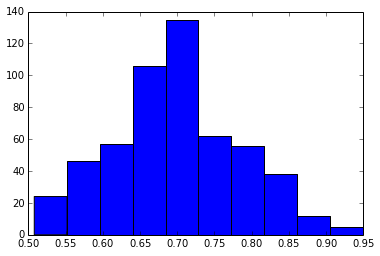

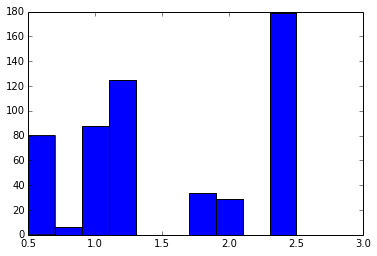

In [53]:
plt.hist(train.spacingY)
plt.show()

plt.hist(train.spacingZ)
plt.show()

## Display Image

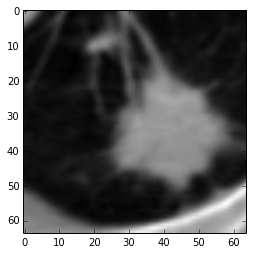

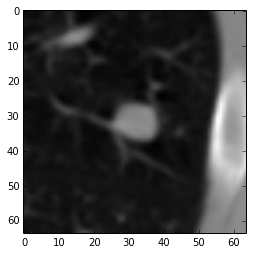

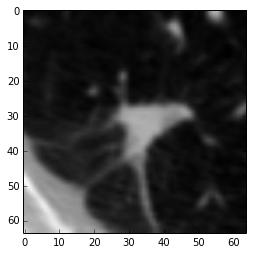

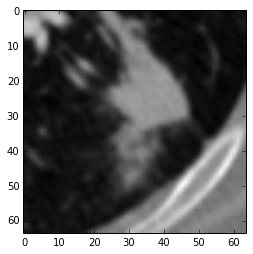

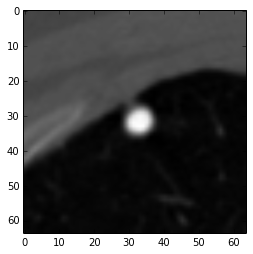

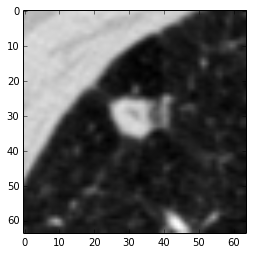

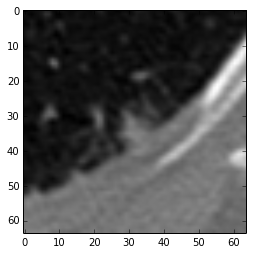

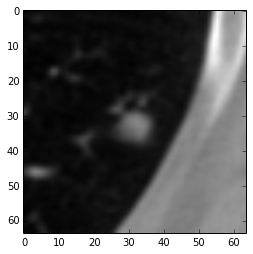

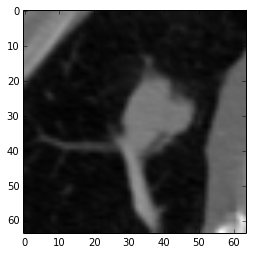

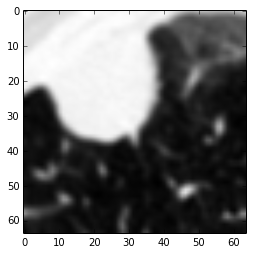

In [41]:
#Get a range in which to subset the data
for i in xrange(10):
    data = train
    class1 = data.loc[(data.Class==1)]
    obs = class1.iloc[np.random.randint(class1.shape[0])]
    #print(obs)
    nvc = np.array([obs.z,obs.y,obs.x]).astype(int)
    mhdPath = obs.seriesuidFullPath.replace(".raw",".mhd")
    itkimage = sitk.ReadImage(mhdPath)
    img = sitk.GetArrayFromImage(itkimage)

    margin = 32
    nvcMinus,nvcPlus = (nvc - margin).astype(int), (nvc + margin).astype(int)
    imgSub = img[nvcMinus[0]:nvcPlus[0],nvcMinus[1]:nvcPlus[1],nvcMinus[2]:nvcPlus[2]]
    def printNoduleInfo():
        print("obs =", obs)
        print("Image shape ==>" + "\n" + str(img.shape))
        print("Nodule coordinates @"+"\n" + str(nvc))
        print("NVC margins ==>" + "\n" + str(nvcMinus) + "\n" + str(nvcPlus))
    #printNoduleInfo()

    def plotNodule():
        from matplotlib.patches import Rectangle
        rectangle = plt.Rectangle((nvcMinus[2], nvcMinus[1]),margin*2 ,margin*2, facecolor = 'none', ec='r')
        circle = plt.Circle((nvc[2],nvc[1]),10, facecolor = 'none', ec='r')
        plt.gca().add_patch(rectangle)
        plt.gca().add_patch(circle)
        plt.imshow(img[nvc[0]],cmap=cm.gray)
        plt.show()

        for i in xrange(nvc[0]-2,nvc[0]+2,1):
            if i == nvc[0]:
                print("Nodule located here")
            print(i)
            plt.imshow(img[i,nvcMinus[1]:nvcPlus[1],nvcMinus[2]:nvcPlus[2]],cmap=cm.gray)
            plt.show()
    plt.imshow(imgSub[32],cmap=cm.gray)
    plt.show()

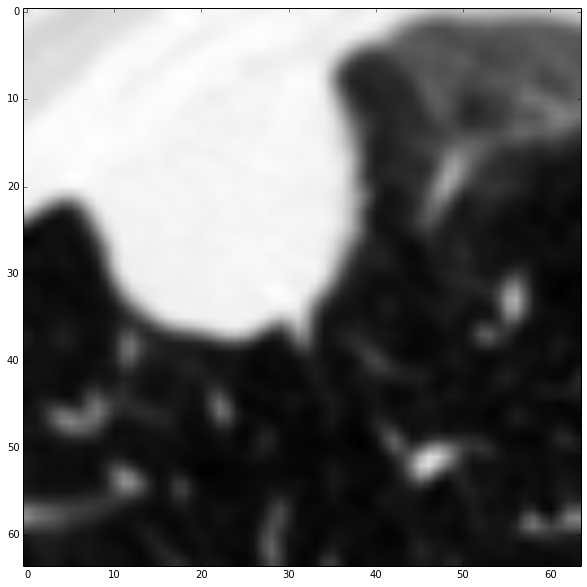

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(imgSub[32],cmap=cm.gray)
plt.show()